In [1]:
# Specify CUDA device
import os
os.environ['CUDA_VISIBLE_DEVICES'] = 'gpu'

from jax import jit, config
config.update("jax_enable_x64", True)

# Check we're running on GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import time

import numpy as np
from jax import jit, grad
import jax.numpy as jnp

from matplotlib import pyplot as plt
from importlib import reload

import scatcovjax.Sphere_lib as sphlib
from scatcovjax.Scattering_lib import scat_cov_axi, scat_cov_dir
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav

import scatcovjax.plotting as plot
plot.notebook_plot_format()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


cpu


# Parameters

In [18]:
sampling = "mw"
multiresolution = True
reality = True

L = 16
N = 1
J_min = 0
#nside = L/2

J = s2wav.utils.shapes.j_max(L)
print(J)

axi = False
if N == 1:
    axi = True

4


# Target map

In [22]:
reload(sphlib)
I, Ilm = sphlib.make_MW_planet(L, 'venus', normalize=True, reality=reality)


(16, 31)
(16, 16)


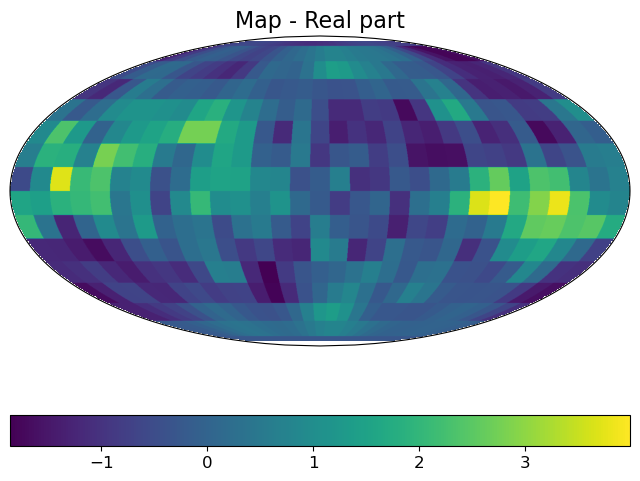

In [23]:
# Plot the map
mx, mn = np.nanmax(I), np.nanmin(I)
plot.plot_map_MW_Mollweide(I, figsize=(8, 6), vmin=mn, vmax=mx)

# Wavelets

(5, 16, 31)


(<Figure size 800x600 with 1 Axes>, <Axes: >)

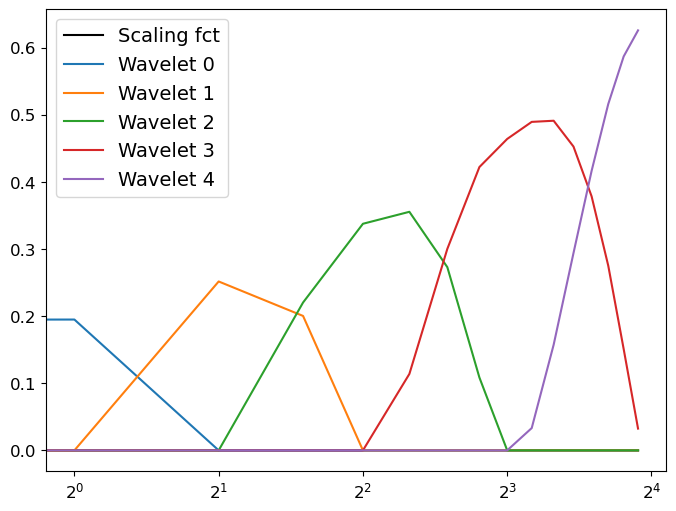

In [24]:
filters = filters_directional_vectorised(L, N, J_min)
print(filters[0].shape)

plot.plot_filters(filters, real=True, m=L-1)

# Compute the coeff of the target

In [26]:
if axi:
    mean, var, S1, P00, C01, C11 = scat_cov_axi(Ilm, L, N, J_min, sampling, None,
                                                reality, multiresolution, filters=filters)
else:
    mean, var, S1, P00, C01, C11 = scat_cov_dir(Ilm, L, N, J_min, sampling, None,
                                                reality, multiresolution, filters=filters)
print(mean, C01)

0.16798434897580836 [ 4.01034210e-04+0.00000000e+00j  9.11456311e-05+0.00000000e+00j
 -1.67058730e-05-1.21672875e-22j  9.47751967e-05+0.00000000e+00j
  6.21534735e-04+5.39643393e-21j -3.13137422e-05-1.29168986e-21j
  4.26436314e-05+0.00000000e+00j  2.15642812e-04-8.99007209e-22j
  6.76571154e-06+2.51453539e-22j  2.17268075e-05-1.80805672e-22j]


# Define the loss

In [27]:
def chi2(model, data):
    return jnp.sum(jnp.abs(data-model)**2)

def func(flm):
    if axi:
        mean_new, var_new, S1_new, P00_new, C01_new, C11_new = scat_cov_axi(flm, L, N, J_min, sampling, 
                                                                            None, reality, multiresolution, 
                                                                            normalisation=None, filters=filters)
    else:
        mean_new, var_new, S1_new, P00_new, C01_new, C11_new = scat_cov_dir(flm, L, N, J_min, sampling, 
                                                                            None, reality, multiresolution, 
                                                                            normalisation=None, filters=filters)
    # Control for mean + var
    loss = chi2(mean, mean_new)
    loss += chi2(var, var_new)
    
    # Add S1 loss
    loss += chi2(S1, S1_new)

    # Add P00 loss
    loss += chi2(P00, P00_new)

    # Add C01 loss
    loss += chi2(C01, C01_new)
    
    # Add C11 loss
    loss += chi2(C11, C11_new)
    
    return loss

#grad_func = jit(grad(func))
grad_func = grad(func)


# Initial condition

In [28]:
f = np.random.randn(L, 2*L-1).astype(np.float64)
flm = s2fft.forward_jax(f, L, reality=reality)
flm = flm[:,L-1:] if reality else flm

flm_start = jnp.copy(flm)
loss_0 = func(flm_start)
print(loss_0)

0.06300335842065659


In [29]:
loss_history = [loss_0]

In [30]:
iterations = 10
momentum = 2.
for i in range(iterations):
    start = time.time()
    flm -= momentum*np.conj(grad_func(flm))
    if i % 1 == 0: 
        end = time.time()
        print(f"Iteration {i}: Loss/Loss-0 = {func(flm):.5f}/{loss_0:.5f}, Momentum = {momentum}, Time = {end - start:.2f} s")
        loss_history.append(func(flm))

Iteration 0: Loss/Loss-0 = 0.05191/0.06300, Momentum = 2.0, Time = 35.30 s
Iteration 1: Loss/Loss-0 = 0.04393/0.06300, Momentum = 2.0, Time = 0.09 s
Iteration 2: Loss/Loss-0 = 0.03776/0.06300, Momentum = 2.0, Time = 0.08 s
Iteration 3: Loss/Loss-0 = 0.03273/0.06300, Momentum = 2.0, Time = 0.09 s
Iteration 4: Loss/Loss-0 = 0.02849/0.06300, Momentum = 2.0, Time = 0.09 s
Iteration 5: Loss/Loss-0 = 0.02487/0.06300, Momentum = 2.0, Time = 0.08 s
Iteration 6: Loss/Loss-0 = 0.02177/0.06300, Momentum = 2.0, Time = 0.59 s
Iteration 7: Loss/Loss-0 = 0.01909/0.06300, Momentum = 2.0, Time = 0.11 s
Iteration 8: Loss/Loss-0 = 0.01675/0.06300, Momentum = 2.0, Time = 0.12 s
Iteration 9: Loss/Loss-0 = 0.01472/0.06300, Momentum = 2.0, Time = 0.11 s


# Check the synthesis

Text(0.5, 0, 'Number of iterations')

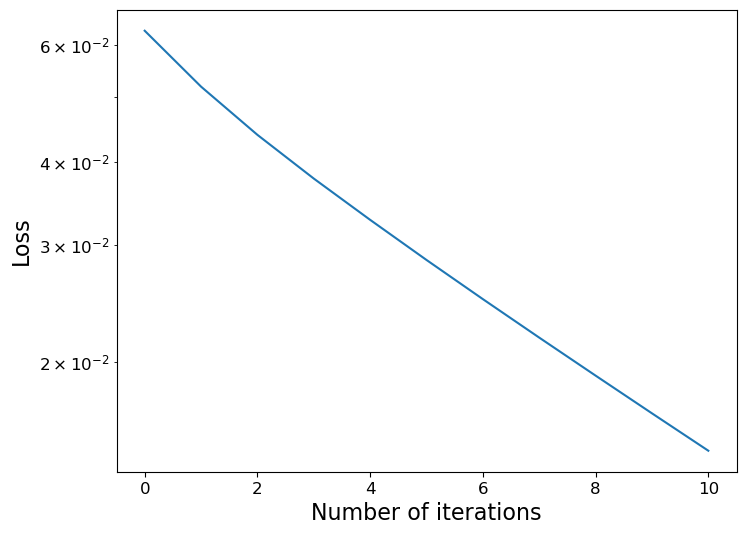

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')

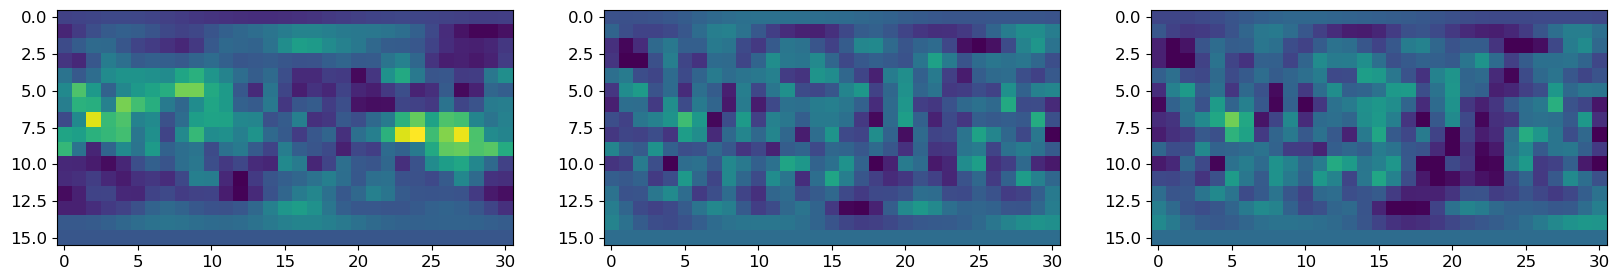

In [32]:
reload(sphlib)
if reality:
    flm_full_target = sphlib.make_flm_full(Ilm, L)
    flm_full_end = sphlib.make_flm_full(flm, L)
    flm_full_start = sphlib.make_flm_full(flm_start, L)
else:
    flm_full_target = Ilm
    flm_full_end = flm
    flm_full_start = flm_start

I = s2fft.inverse_jax(flm_full_target, L, reality=reality)
f_start = s2fft.inverse_jax(flm_full_start, L, reality=reality)
f_end = s2fft.inverse_jax(flm_full_end, L, reality=reality)

fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(I, vmax=mx, vmin=mn, cmap='viridis')
ax2.imshow(f_start, vmax=mx, vmin=mn, cmap='viridis')
ax3.imshow(f_end, vmax=mx, vmin=mn, cmap='viridis')
plt.show()

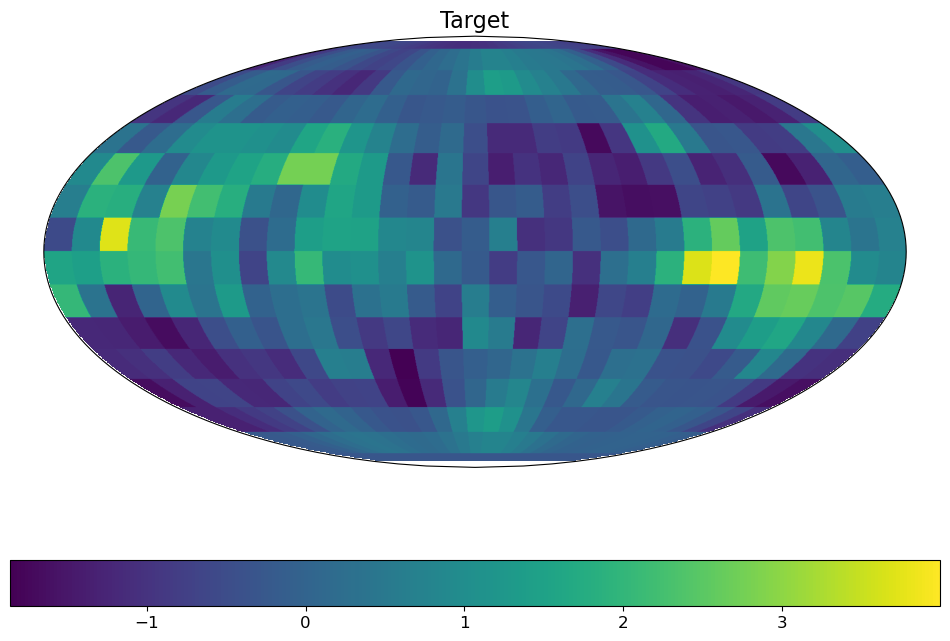

In [33]:
plot.plot_map_MW_Mollweide(I, vmin=mn, vmax=mx, title='Target')

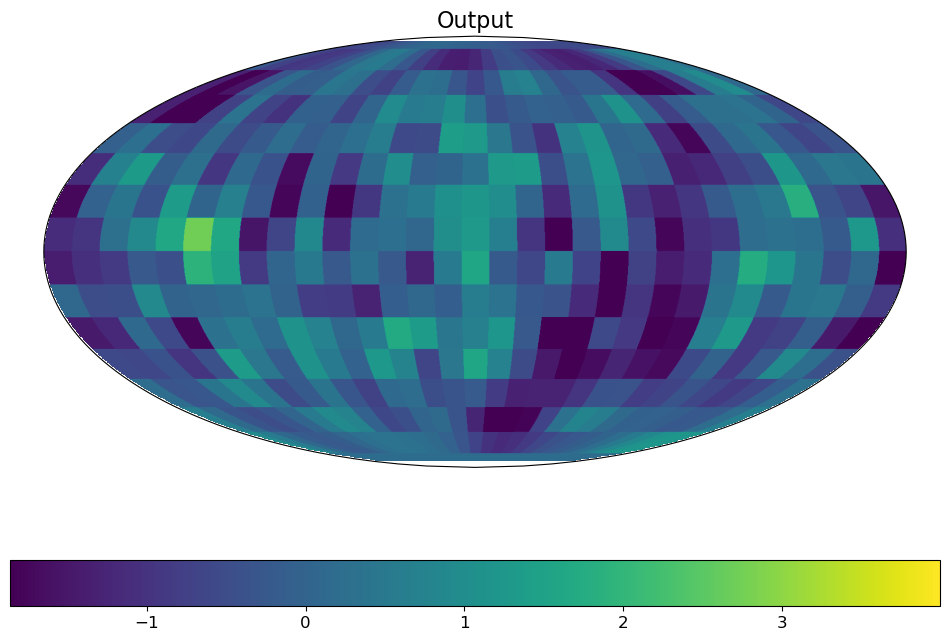

In [34]:

plot.plot_map_MW_Mollweide(f_end, vmin=mn, vmax=mx, title='Output', central_longitude=0)

### Power spectrum

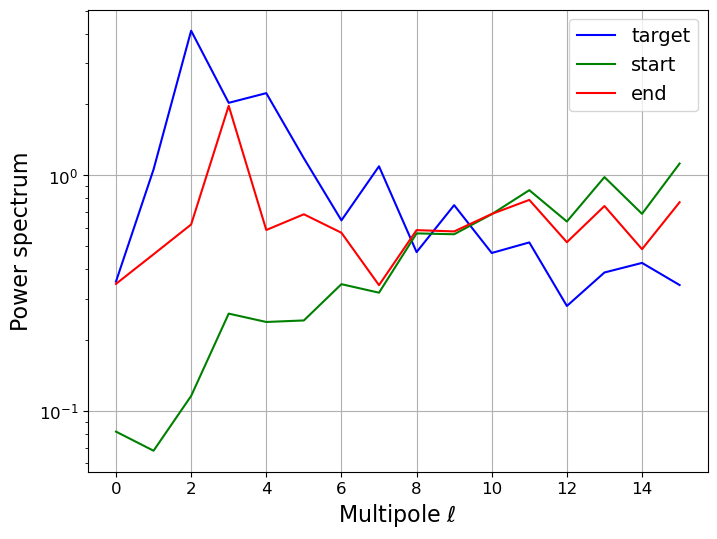

In [42]:
reload(sphlib)
ps_target = sphlib.compute_ps(flm_full_target)
ps_start = sphlib.compute_ps(flm_full_start)
ps_end = sphlib.compute_ps(flm_full_end)

plt.figure(figsize=(8, 6))
plt.plot(ps_target, 'b', label="target")
plt.plot(ps_start, 'g', label="start")
plt.plot(ps_end, 'r', label="end")
plt.yscale("log")
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
plt.legend()

### Plot the coefficients

In [38]:
mean_target, var_target, S1_target, P00_target, C01_target, C11_target = scat_cov_axi(flm_full_target, L, N, J_min, sampling, None,
                                                                                      reality=False,
                                                                                      multiresolution=multiresolution,
                                                                                      filters=filters)
mean_start, var_start, S1_start, P00_start, C01_start, C11_start = scat_cov_axi(flm_full_start, L, N, J_min, sampling, None,
                                                                                reality=False,
                                                                                multiresolution=multiresolution,
                                                                                filters=filters)
mean_end, var_end, S1_end, P00_end, C01_end, C11_end = scat_cov_axi(flm_full_end, L, N, J_min, sampling, None,
                                                                    reality=False,
                                                                    multiresolution=multiresolution,
                                                                    filters=filters)

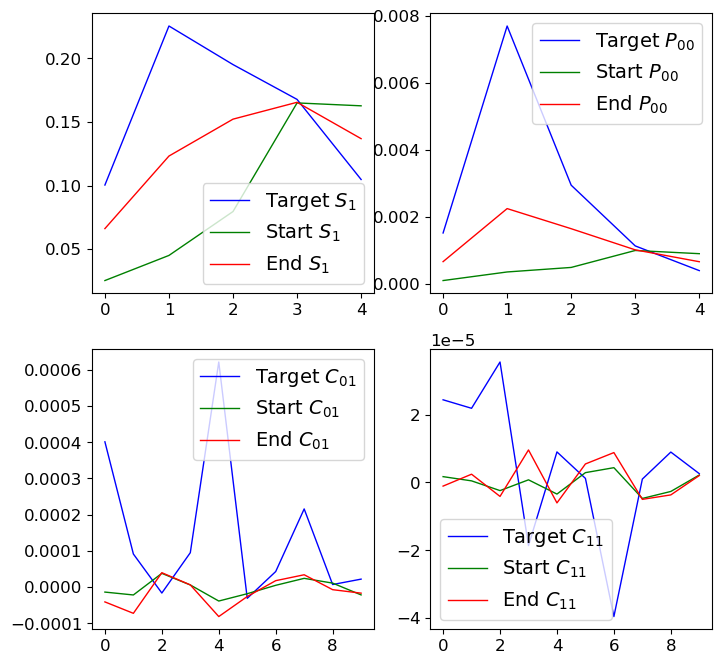

In [51]:
reload(plot)
plot.plot_scatcov_coeffs(S1_target, P00_target, C01_target, C11_target, name='Target', hold=True, color='blue', lw=1)

plot.plot_scatcov_coeffs(S1_start, P00_start, C01_start, C11_start, name='Start', hold=False, color='green', lw=1)

plot.plot_scatcov_coeffs(S1_end, P00_end, C01_end, C11_end, name='End', hold=False, color='red', lw=1)